# Predicting Diabetes using Multilayer Perceptrons (MLP)

First, we start by importing the necessary libraries to read and clean the data. The dataset is downloaded from https://www.kaggle.com/uciml/pima-indians-diabetes-database as `diabetes.csv`

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Let's visualize the distribution of each variable in the dataset by plotting their histograms

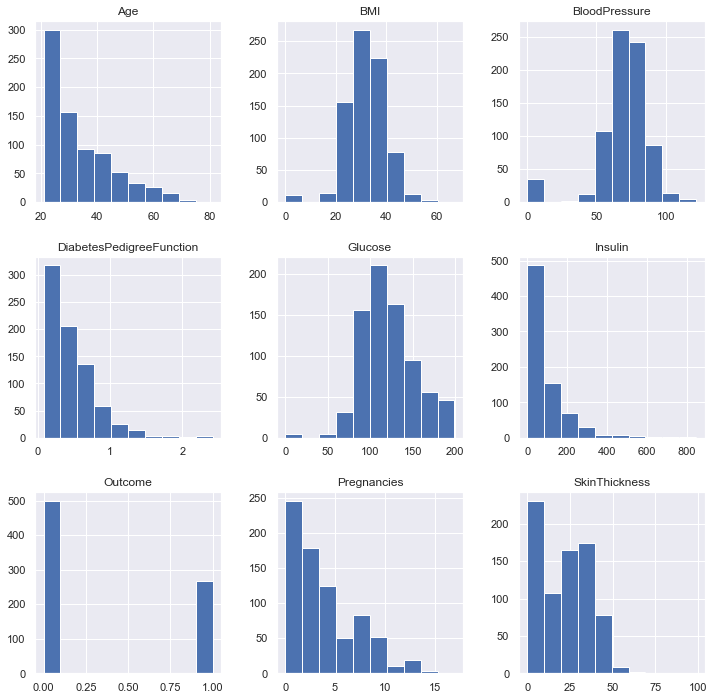

In [3]:
df.hist(figsize=(12,12))
plt.show()

We notice the following:
- The dataset consists of mostly young people in their 20s and 30s
- BMI, blood pressure, and Glucose are normally distributed, however there are quite a few people on the extreme end of the Glucose attribute (almost 200), and on the other hand, there are some people with value zero which is not possible
- There are some extreme outliers in the Pregnancies attribute (over 10) which could skew the results
- There are about 1/3 of the surveyed population having diabetes (Outcome = 1) but the global average is believed to be much lower

Let's look at each attribute in more detail using density plots

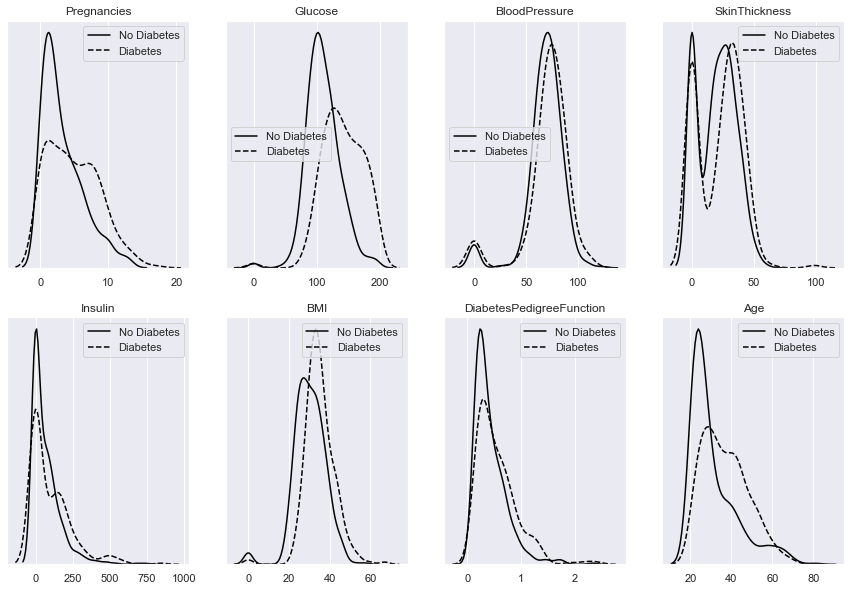

In [4]:
plt.subplots(2, 4, figsize=(15,10))

# Excluding the last column which is the outcome
for i, col in enumerate(df.columns[:-1]):
    ax = plt.subplot(2, 4, i+1)
    ax.set_yticks([])
    sns.distplot(df.loc[df.Outcome==0][col],
                 hist=False,
                 axlabel=False,
                 kde_kws={'linestyle':'-', 'color':'black', 'label':"No Diabetes"})
    sns.distplot(df.loc[df.Outcome==1][col],
                 hist=False,
                 axlabel=False,
                 kde_kws={'linestyle':'--', 'color':'black', 'label':"Diabetes"})
    ax.set_title(col)
plt.show()

The above plots give us some insights:
- __Blood pressure__ and __skin thickness__ are not good predictors for our model since these distributions among non-diabetics and diabetics are about the same
- Strong indicators can include __Glucose, BMI,__ and __Age__ since in these attributes, distributions among the 2 groups are quite different

### Data preprocessing

In [5]:
# Check if there are any missing value
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

There aren't any missing value, but we have noted above that there are some impossible zeros in the _Glucose, Blood pressure, Skin thickness, Insulin,_ and _BMI_ attributes. Let's take a closer look

In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


As expected, the min value of these attributes are 0, probably because instead of having missing inputs, the data collectors decided to put 0. Whichever case it is, we need to handle these 0 values

In [7]:
print("Number of rows with 0 values for each variable:")
for col in df.columns[:-1]:
    print(f"- {col}: {df.loc[df[col]==0].shape[0]}")

Number of rows with 0 values for each variable:
- Pregnancies: 111
- Glucose: 5
- BloodPressure: 35
- SkinThickness: 227
- Insulin: 374
- BMI: 11
- DiabetesPedigreeFunction: 0
- Age: 0


We can see that there are lots of impossible zeros in the data that we cannot simply discard them. Let's instead replace them with the mean of each attribute (without counting the zeros into the mean value of course)

In [8]:
# Grab the columns from Glucose to BMI
total_rows = df.shape[0]
for col in df.columns[1:6]:
    num_of_zeros = df.loc[df[col]==0].shape[0]
    mean = df[col].sum() / (total_rows - num_of_zeros)
    df[col] = df[col].replace(0, mean)

In [9]:
# Verify again if there aren't any more zeros in the modified columns while observing their mean values slightly going up
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.790942,85.021108,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.153420,155.548223,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


The minimum values for the columns from __Glucose__ to __BMI__ seem more correct, good

### Data normalization

In [10]:
# Import the preprocessing class from sklearn to normalize the data in such a way that its attributes' means are zero and variances are 1
from sklearn import preprocessing

df_norm = pd.DataFrame(preprocessing.scale(df), columns=df.columns)
df_norm.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.865108,-0.033518,6.655021e-01,-3.345079e-16,0.166292,0.468492,1.425995,1.365896
1,-0.844885,-1.206162,-0.529859,-1.746338e-02,-3.345079e-16,-0.852531,-0.365061,-0.190672,-0.732120
2,1.233880,2.015813,-0.695306,8.087936e-16,-3.345079e-16,-1.332833,0.604397,-0.105584,1.365896
3,-0.844885,-1.074652,-0.529859,-7.004289e-01,-7.243887e-01,-0.634212,-0.920763,-1.041549,-0.732120
4,-1.141852,0.503458,-2.680669,6.655021e-01,1.465506e-01,1.548980,5.484909,-0.020496,1.365896


In [11]:
# Restore the Outcome column to the original values of 0 and 1
df_norm['Outcome'] = df['Outcome']

# Check if all column's means and variances are correct (in this case standard deviation since it's the sqrt of variance)
df_norm.describe().loc[['mean', 'std']].round(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
mean,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.35
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.48


### Splitting the dataset into training, testing, and validation sets

We will split the data into the following 3 sets:
- __Training set__: to train the neural network. This set will make up about 65% of the total data
- __Validation set__: to fine-tune the hyperparameter (biases, weights, number of hidden layers and nodes...). About 15% of the total data
- __Testing set__: to evaluate the performance of the neural network. About 20% of the total data

In [24]:
from sklearn.model_selection import train_test_split

# First, separate the last column from the dataset as it is the true outcome of the model
X = df.loc[:, df.columns!='Outcome']
y = df.loc[:, 'Outcome']

# Next, split the data into sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print("Size of training set:", X_train.shape[0])
print("Size of validating set:", X_val.shape[0])
print("Size of testing set:", X_test.shape[0])

Size of training set: 491
Size of validating set: 123
Size of testing set: 154


### Modeling a MLP neural network

The data is ready for feeding into the neural network. We are going to use keras to construct a DNN with 2 hidden layers, in which the ReLU activation function is used for these 2 hidden layers and Sigmoid is used for the output layer.

In [13]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                288       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Let's compile the model the train it
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, verbose=1)

Epoch 1/200
16/16 [==============================] - 0s 23ms/step - loss: 0.5621 - accuracy: 0.7413 - val_loss: 0.3882 - val_accuracy: 0.8374
Epoch 2/200
16/16 [==============================] - 0s 13ms/step - loss: 0.4750 - accuracy: 0.7699 - val_loss: 0.3806 - val_accuracy: 0.8211
Epoch 3/200
16/16 [==============================] - 0s 11ms/step - loss: 0.4743 - accuracy: 0.7719 - val_loss: 0.3935 - val_accuracy: 0.8293
Epoch 4/200
16/16 [==============================] - 0s 12ms/step - loss: 0.4544 - accuracy: 0.7719 - val_loss: 0.4262 - val_accuracy: 0.8049
Epoch 5/200
16/16 [==============================] - 0s 11ms/step - loss: 0.4698 - accuracy: 0.7678 - val_loss: 0.4825 - val_accuracy: 0.7724
Epoch 6/200
16/16 [==============================] - 0s 11ms/step - loss: 0.4441 - accuracy: 0.7760 - val_loss: 0.4500 - val_accuracy: 0.8211
Epoch 7/200
16/16 [==============================] - 0s 11ms/step - loss: 0.4429 - accuracy: 0.7882 - val_loss: 0.3947 - val_accuracy: 0.8130
Epoch 

In [26]:
# Let's evaluate the model
scores_train = model.evaluate(X_train, y_train)
scores_test = model.evaluate(X_test, y_test)
print("Training accuracy: %.2f%%" % (scores_train[1]*100))
print("Testing accuracy: %.2f%%" % (scores_test[1]*100))

5/5 [==============================] - 0s 4ms/step - loss: 0.5152 - accuracy: 0.7792
Training accuracy: 80.24%
Testing accuracy: 77.92%


### Model evaluation by confusion matrix and ROC curve

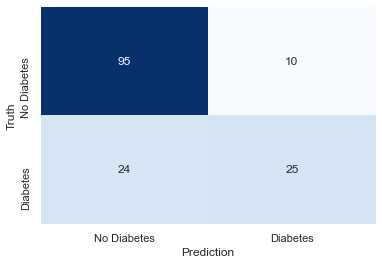

In [29]:
from sklearn.metrics import confusion_matrix, roc_curve

prediction = (model.predict(X_test) > 0.5).astype(int)
matrix = confusion_matrix(y_test, prediction)
ax = sns.heatmap(matrix, annot=True, xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'], cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")
plt.show()

We see that the number of true negative and true positive is pretty good, as the model gets the correct classification 78% of the time. However, the number of false negative is still quite high compared to false positive. Let's look at the Receiver Operating Characeristic (ROC) curve

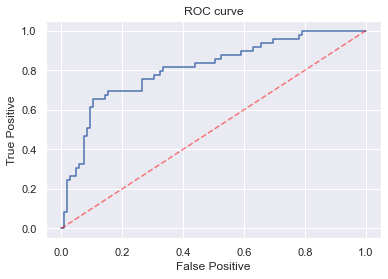

In [31]:
prediction_proba = model.predict(X_test)
false_pos, true_pos, _ = roc_curve(y_test, prediction_proba)

plt.plot(false_pos, true_pos)
plt.plot([0,1], [0,1], '--', color='red', alpha=0.5)  # diagonal reference line
plt.title("ROC curve")
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.show()

__The above curve shows that our model performs rather well!__

In [32]:
# Save the model for future use
model.save("diabetes_predictor_model.h5")